# Анализ пользовательского поведения в мобильном приложении по продаже продуктов питания

### Ход исследования

1. [Подготовка данных:](#start)
- загрузка данных;
- обзор и предобработка выгруженных данных. О качестве данных ничего неизвестно, поэтому перед тем как приступать к целям исследования, потребуется их обзор: *проверим данные на пропуски и оценим их влияние на исследование. Осуществим проверку на явные дубликаты. Затем на этапе предобработки поищем возможность заполнить/удалить пропуски в данных, которые не приведут к искажению конечного результата. Преобразуем типы данных в колонках соответственно сохранённым в них значениям.*
2. [Изучение и проверка данных, в т.ч. определение с какого момента данные полные и исключение более старых.](#actual_data)
3. [Изучение воронки событий:](#event_funnel)
- определение порядка событий и какое из них не стоит учитывать в воронке;
- определение доли пользователей для каждого шага, а также долю пользователей, которые дошли от первого события до оплаты.
4. [Проверка результатов А/А-теста на корректность работы разбиения на группы:](#a_a_test)
- проверка на равенство размеров изучаемых выборок и неперсечения пользователей;
- проверка равенства долей.
5. [Изучение результатов А/А/В-теста и принятие решения о приостановке эксперимента и определению какой шрифт лучше (или о продолжении эксперимента):](#a_a_b_test)
- проверка равенства долей с каждой контрольной группой;
- проверка равенства долей с объединенными контрольными группами.
6. [Общий вывод.](#conclusion)

### Подготовка данных
<a id="start"></a> 

In [1]:
#вызываем функцию игнорирования предупреждений
import warnings
warnings.filterwarnings('ignore')

#импорт библиотек, необходимых для проведения анализа
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
import math as mth

In [2]:
#выгружаем файл с данными
data = pd.read_csv('https://...', sep='\t')

#выведем на экран первые 5 строк, выгруженного датасета
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [3]:
#переименуем названия столбцов
data = data.rename(
    columns={
        'EventName' : 'event_name',
        'DeviceIDHash' : 'user_id',
        'EventTimestamp' : 'event_ts',
        'ExpId' : 'group'
    }
)
#выведем на экран первые 5 строк, полученного датасета
data.head()

,event_name,user_id,event_ts,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
#выведем общую информацию о файле
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   event_name  244126 non-null  object
 1   user_id     244126 non-null  int64 
 2   event_ts    244126 non-null  int64 
 3   group       244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Выгрузив и изучив данные видим, что пропуски в данных отсутствуют. При этом сами данные столбца event_ts не представлены ввиде даты, в т.ч. и тип данных самого столбца. Как видим в самом столбце данные представлены в формате unix time (количество секунд, прошедших с 00:00:00 1 января 1970 года). Преобразуем его, а также создадим отдельный столбец с датой:

In [5]:
#представим данные столбца event_ts в виде даты и времени
data['event_ts'] = pd.to_datetime(data['event_ts'], unit='s')

#добавим столбец event_date, в котором будет отображены только дата вычлененная из столбца event_ts
data['event_date'] = data['event_ts'].dt.date

#преобразуем тип данных столбца event_date в datetime
data['event_date'] = pd.to_datetime(data['event_date'])

#выведем данные о полученных столбцах
data[['event_ts', 'event_date']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_ts    244126 non-null  datetime64[ns]
 1   event_date  244126 non-null  datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 3.7 MB


Дату и время получили, столбец с датой вывели. Типы данных в указанных столбцах соотвествуют их значениям.

Теперь осуществим проверку на дубликаты:

In [6]:
#посчитаем количество дубликатов в нашем датафрейме
data.duplicated().sum()

413

Оказывается в датафрейме 413 дубликатов. Удалим их и выведем полученное количество строк, преобразованного датасета:

In [7]:
#удалим явные дубликаты и сразу пересчитаем индексы
data = data.drop_duplicates().reset_index(drop=True)

#выведем полученное итоговое количество строк датафрейма
data.shape[0]

243713

Количество строк уменьшилось (было 244 126) на количество дубликатов.

### Изучение и проверка данных
<a id="actual_data"></a> 

**Посмотрим сколько всего событий в логе:**

In [8]:
#построим сводную таблицу, сгруппировав по столбцу event_name и выведем количество каждого
data.pivot_table(
    index = 'event_name',
    aggfunc = 'count',
    margins = 'All' #выведем итоговую сумму, чтобы проверить себя, что мы не ошиблись в вычислениях, общее кол-во строк должно
)[                  #получиться равное количеству строк датафрейма или 243 713
    'user_id'
].reset_index(
).rename(
    columns={'user_id' : 'count'})

,event_name,count
0,CartScreenAppear,42668
1,MainScreenAppear,119101
2,OffersScreenAppear,46808
3,PaymentScreenSuccessful,34118
4,Tutorial,1018
5,All,243713


Получается у нас всего 5 событий:
- MainScreenAppear - Входная страница
- PaymentScreenSuccessful - Успешная оплата заказа
- CartScreenAppear - Корзина
- OffersScreenAppear - Каталог
- Tutorial - Инстуркция о функционале приложения.

**Посчитаем сколько всего пользователей в логе:**

In [9]:
#посчитаем количество уникальных пользоваталей с помощью метода nunique()
data['user_id'].nunique()

7551

Количество уникальных пользователей в датафрейме - 7 551.

**Посчитаем сколько в среднем событий приходится на пользователя:**

In [10]:
"{0:.0f}".format( #представим полученные данные в целых числах
    data['event_name'].count() / data['user_id'].nunique() #поделим общее кол-во событий на кол-во уникальных пользоваталей
)

'32'

Рассчитав среднееарифметическое получили, что в среднем на 1-го пользователя приходится 32 события.

Рассмотрим среднее значение через призму гистограммы и медианного значения:

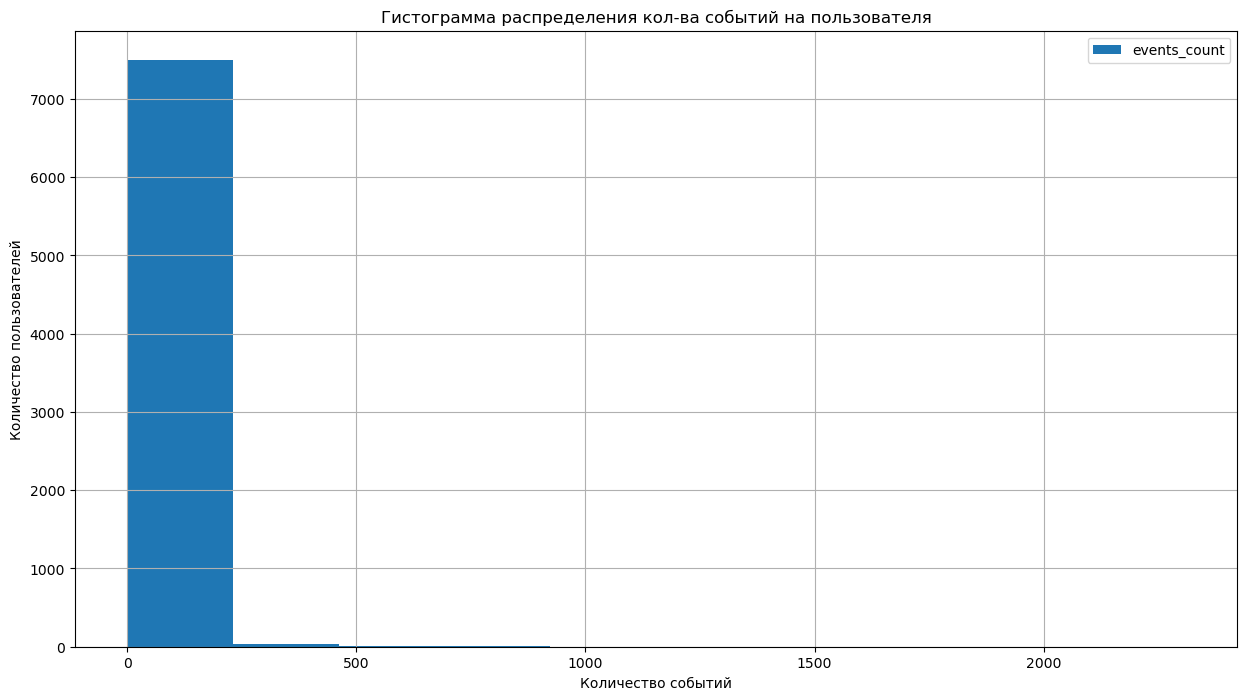

In [11]:
data.groupby( #сгруппируем датасет по пользователям
    'user_id', as_index=False
)['event_name'].count( #посчитав сколько событий приходится на каждого пользователя
).rename(
    columns={'event_name':'events_count'}
).drop(
    ['user_id'], axis=1
).plot(
    kind='hist', #построим гистограмму
    title='Гистограмма распределения кол-ва событий на пользователя',
    legend=True,
    figsize=(15,8),
    grid=True
)

#зададим наименования осям
plt.xlabel('Количество событий')
plt.ylabel('Количество пользователей');

В таком формате гистограмма не наглядна и ее сложно интерпритировать, т.к. большое скопление данных в районе от 0 до 200 количеств событий на 1 пользователя и очень длинный хвост в сторону редкого количества событий на одного пользователя в размере 2 000. Построим диаграмму "ящика с усами" для наглядности:

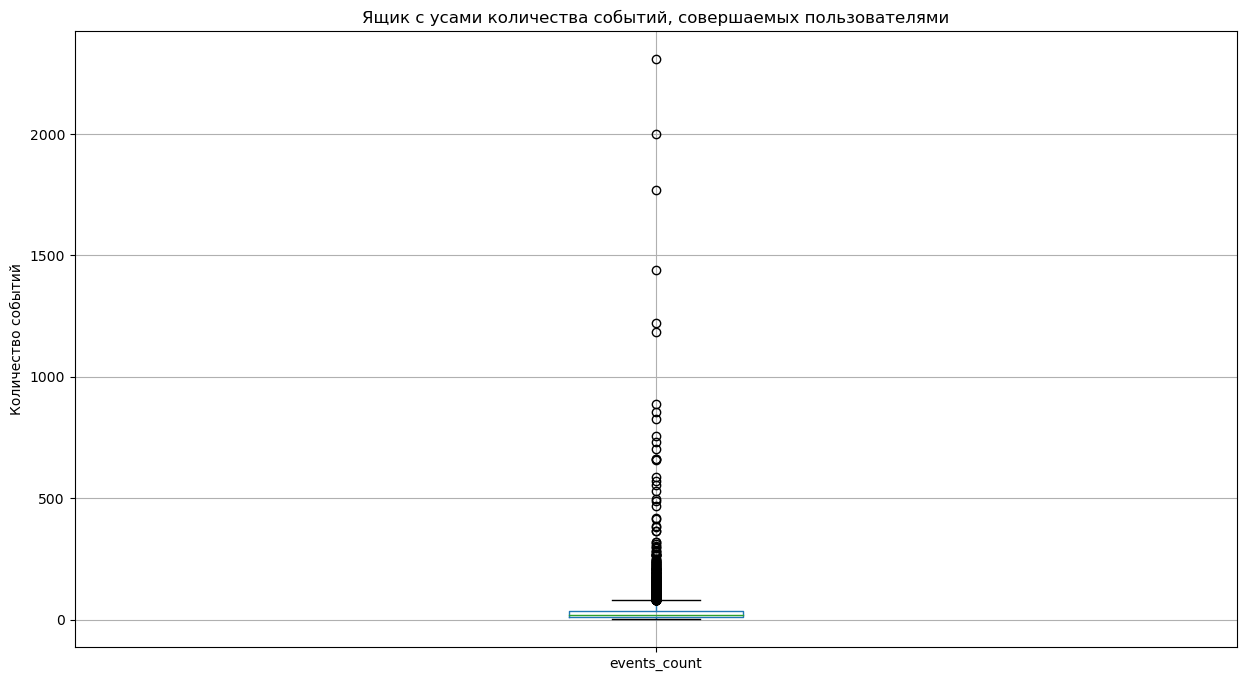

In [12]:
#построим "ящик с усами"
data.groupby(
    'user_id', as_index=False
)['event_name'].count(
).rename(
    columns={'event_name':'events_count'}
).drop(
    ['user_id'], axis=1
).boxplot(
    figsize=(15,8)
)

#добавим подписи к графику
plt.title('Ящик с усами количества событий, совершаемых пользователями')
plt.ylabel('Количество событий');

Видим, что значения свыше 1 000 количества событий на 1 пользователя очень редко повторяются. Основная часть пользователей с повторяющимся количеством событий лежит внизу боксплота.


Построим еще раз гистограмму, но уже поменяем границы рассматриваемого интервала количества событий на одного пользователя и добавим "корзин":

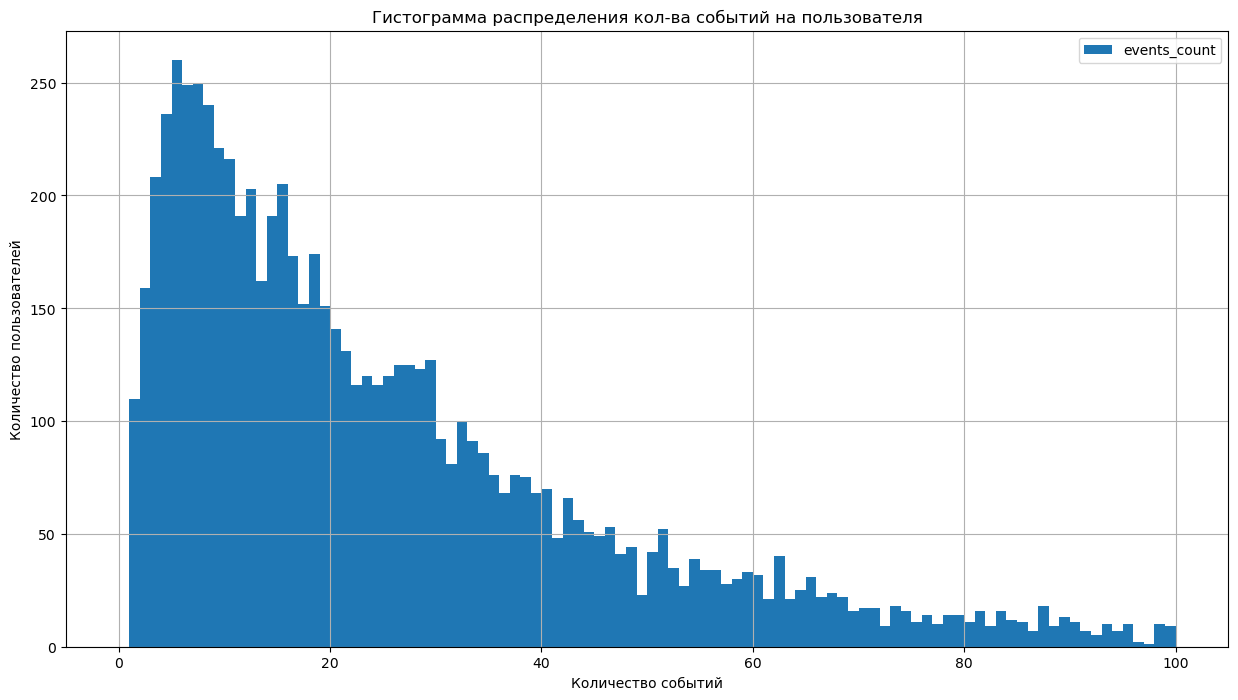

In [13]:
#построим гистограмму задав ему интервал от 0 до 100 (range=(0,100)) и количетво "корзин" равное 100 (bins=100)
data.groupby(
    'user_id', as_index=False
)['event_name'].count(
).rename(
    columns={'event_name':'events_count'}
).drop(
    ['user_id'], axis=1
).plot(
    kind='hist', #построим гистограмму
    title='Гистограмма распределения кол-ва событий на пользователя',
    legend=True,
    figsize=(15,8),
    grid=True,
    range=(0,100),
    bins=100
)

#зададим наименования осям
plt.xlabel('Количество событий')
plt.ylabel('Количество пользователей');

На данной гистограмме уже лучше видно распределение количества событий на пользователя. И можно предположить, что медианное значение расположено в районе 20 повторений на одного пользователя. Проверим - посчитаем медиану:

In [14]:
#рассчитаем медианну
data['user_id'].value_counts().median()

20.0

Т.к. наши данные очень разбросаны от небольшого количества событий на одного пользователя до очень больших, корректнее за среднее значение событий, которое приходится на пользователя, брать не среднее арифметическое, а мединау, то есть **в среднем на одного пользователя приходится около 20 событий.**

**Определим данными за какой период мы располагаем.**

Сперва найдем минимальную и максимульную даты рассматриваемого периода:

In [15]:
display(
    data['event_date'].min(),
    data['event_date'].max()
)

Timestamp('2019-07-25 00:00:00')

Timestamp('2019-08-07 00:00:00')

Рассматриваемый нами период с 25 июля 2019 года по 7 августа 2019 года или 14 дней.

Построим график количества событий по дням:

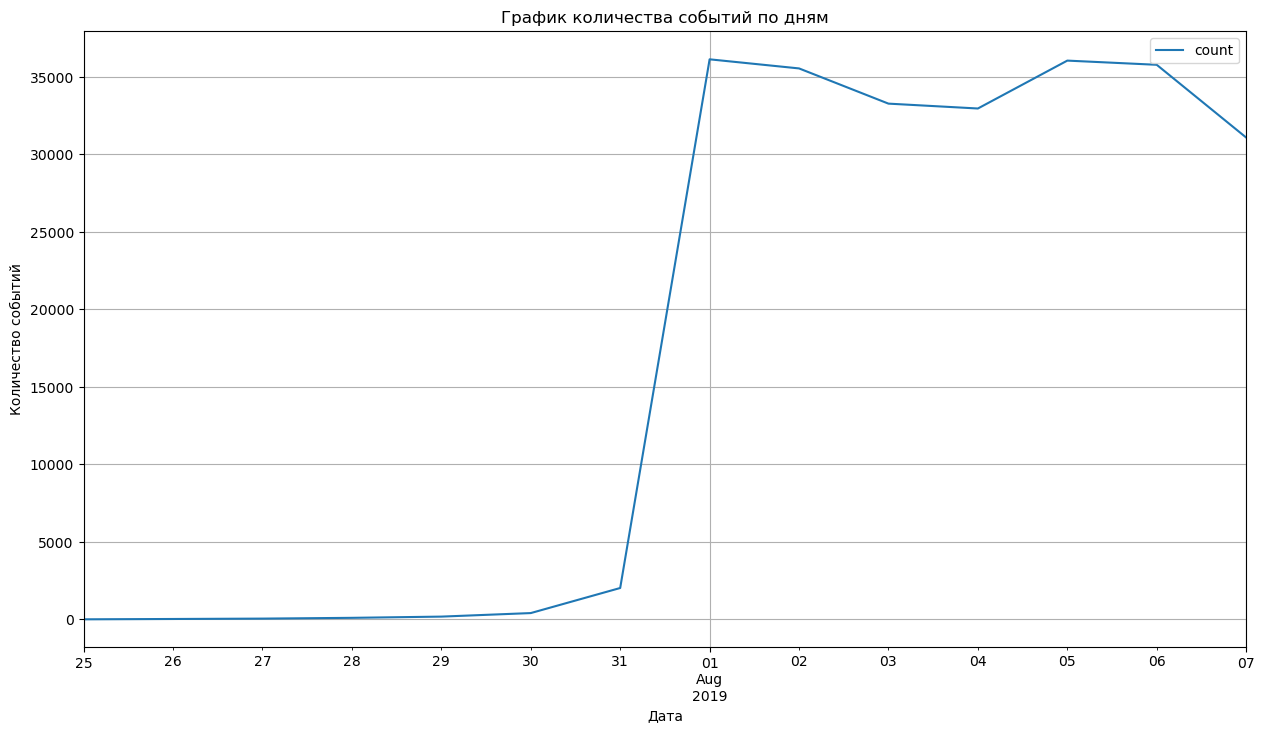

In [16]:
data.groupby(
    'event_date' #сгруппируем данные по датам
).agg(
    {'event_name' : 'count'} #посчитаем количество событий на каждую дату
).rename(  #переименуем столбец
    columns={'event_name' : 'count'}
).plot(
    kind='line',
    figsize=(15,8),
    grid=True,
    xlabel='Дата',
    ylabel='Количество событий',
    title='График количества событий по дням'
);

По графику четко видно, что в логи новых дней по некоторым пользователям «доезжают» события из прошлого — это может «перекашивать данные». Поэтому, начиная с 1 августа данные полные. Остальные следует отбросить. Тогда исследуемый период времени будет с 01.08.2019 по 07.08.2019.

Измерим сколько событий мы потеряем отбросив период с 25.07.2019 по 31.07.2019:

In [17]:
#посчитаем количество событий, которые мы потеряем, отсеяв "доезжающие" и долю этих событий во всем датафрейме
display(
    data.query('"25-07-2019" <= event_date <= "31-07-2019"')['event_name'].count(),
    "{:.1%}".format(
        data.query('"25-07-2019" <= event_date <= "31-07-2019"')['event_name'].count() / data['event_name'].count()
    )
)

2826

'1.2%'

Также узнаем сколько потеряется пользователей за указанный период:

In [18]:
#посчитаем количество уникальных пользователей, которых мы потеряем, отсеяв "доезжающие" события
data.query('"25-07-2019" <= event_date <= "31-07-2019"')['user_id'].nunique()

1451

Получается, отсеяв данные в период с 25.07.2019 по 31.07.2019, мы потеряем 1,2% всех событий и 1 451 пользователей, оформлявших покупки в этот период.

Перезапишем данные, которые будем использовать в дальнейшем анализе, оставив данные за период с 01.08.2019 по 07.08.2019:

In [19]:
#отсечем все данные, которые меньше 2019-08-01
data = data.query('event_date >= "2019-08-01"').reset_index(drop=True)

### Изучим воронку событий
<a id="event_funnel"></a> 

**Посмотрим, какие события есть в логах и как часто они встречаются:**

In [20]:
#сгруппируем данные по событиям и посчитаем количество каждого
data.groupby(
    'event_name', as_index=False
).agg(
    {'user_id' : 'count'}
).sort_values( #отсортируем данные в порядке убывания кол-ва событий
    by='user_id', ascending=False
).rename(
    columns={'user_id' : 'count'}
)

,event_name,count
1,MainScreenAppear,117328
2,OffersScreenAppear,46333
0,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


Видим воронку продаж в следующем порядке:
- MainScreenAppear - Входная страница
- OffersScreenAppear - Каталог
- CartScreenAppear - Корзина
- PaymentScreenSuccessful - Успешная оплата заказа
- Tutorial - Инстуркция о функционале приложения.

**Теперь посчитаем сколько пользователей совершали каждое из этих событий:**

In [21]:
#сгруппируем данные по событиям и посчитаем количество уникальных пользователей в каждом
data.groupby(
    'event_name', as_index=False
).agg(
    {'user_id' : 'nunique'}
).sort_values( #отсортируем данные в порядке убывания кол-ва уникальных пользователей
    by='user_id', ascending=False 
).rename(
    columns={'user_id' : 'users'}
)

,event_name,users
1,MainScreenAppear,7419
2,OffersScreenAppear,4593
0,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


Видим, что данные по пользователям в каждом из событий расположены в той же очередности, что и по количеству событий. Также сперва основная пользователей посещает главную страницу, затем переходит в каталог, после чего в корзину, затем на страницу успешной оплаты (после совершения оплаты). При этом инструкцию о функционале приложения смотрят лишь некоторые. 

Посчитаем также долю пользователей, которые хоть раз совершили событие:

In [22]:
#поделим количество пользователей перешедших из главной страницы в каталог
"{:.1%}".format(
    data[data['event_name'] == 'OffersScreenAppear']['user_id'].nunique() /\
    data[data['event_name'] == 'MainScreenAppear']['user_id'].nunique()
)

'61.9%'

Получается почти 62% пользователей зашедших в приложение переходят в раздел каталог к выбору покупок.

Как мы увидели ранее все события выстраиваются в воронку продаж в том порядке, в котором убывает количество событий или количество уникальных пользователей, за исключением события Tutorial -  в данный раздел только те пользователи, которые хотели бы разобраться с функционалом приложения и его можно не учитывать при расчете воронки продаж.

**По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем):**

In [23]:
#посчитаем долю пользователей перешедших с одного шага на другой
display(
    f"Доля пользователей, перешедших с главной страницы в каталог - \
{round(data[data['event_name'] == 'OffersScreenAppear']['user_id'].nunique()/data[data['event_name'] == 'MainScreenAppear']['user_id'].nunique()*100)}%",
    f"Доля пользователей, добавивших из каталога продукты в корзину - \
{round(data[data['event_name'] == 'CartScreenAppear']['user_id'].nunique()/data[data['event_name'] == 'OffersScreenAppear']['user_id'].nunique()*100)}%",
    f"Доля пользователей, совершивших оплату после добавления товаров в корзину - \
{round(data[data['event_name'] == 'PaymentScreenSuccessful']['user_id'].nunique()/data[data['event_name'] == 'CartScreenAppear']['user_id'].nunique()*100)}%",
)

'Доля пользователей, перешедших с главной страницы в каталог - 62%'

'Доля пользователей, добавивших из каталога продукты в корзину - 81%'

'Доля пользователей, совершивших оплату после добавления товаров в корзину - 95%'

Как видим наибольшее количество пользователей теряется на шаге пользователей перешедших с главной страницы в каталог. По остальным шагам воронки провалов как таковых нет и уровень конверсии довольно высокий.

**Посмотрим еще какая доля пользователей дошла от первого события до оплаты:**

In [24]:
#посчитаем долю пользователей, которые дошли от первого шага до оплаты,
#разделив кол-во пользователей из события PaymentScreenSuccessful на тех, кто из MainScreenAppear
"{:.1%}".format(
    data[data['event_name'] == 'PaymentScreenSuccessful']['user_id'].nunique() /\
    data[data['event_name'] == 'MainScreenAppear']['user_id'].nunique()
)

'47.7%'

Получается, что почти каждый второй пользователь, зашедший в приложение совершает покупку - довольно неплохая конверсия в оплату.

Сформируем сводную таблицу по полученным данным для наглядности:

In [25]:
#создадим сводную таблицу сгруппировав данные по событиям и посчитаем кол-во уникальных пользователей в каждой
sales_funnel = data.pivot_table(
    index='event_name',
    values='user_id',
    aggfunc='nunique',
    margins='All' #выведем тоговую строку
).rename(
    columns={'user_id':'uniq_users'} #переименуем колонку
).drop(
    'Tutorial', axis=0 #удалим значения события Tutorial, т.к. они нам не нужны для анализа воронки
).reset_index(
).sort_values(
    by='uniq_users', ascending=False #отсортируем данные по убыванию кол-ва пользователей
)

#добавим столбец с долей уникальных пользователей от их общего числа
sales_funnel['part_uniq_users'] = np.array(sales_funnel['uniq_users'])/\
                                  np.array(sales_funnel[sales_funnel['event_name']=='All']['uniq_users'])

#добавим столбец с конверсией в переход с предыдущего шага
sales_funnel['conv_prev_step'] = sales_funnel['uniq_users']/sales_funnel['uniq_users'].shift(1)

#посчитаем потерю пользователей при переходе
sales_funnel['transition_loss'] = 1 - sales_funnel['conv_prev_step']


sales_funnel = sales_funnel.set_index('event_name') #сделаем индексами столбец с наименованием событий,
sales_funnel = sales_funnel.drop(['All'], axis=0) #чтобы удалить строку со значениями итогов

#выведем полученную таблицу
sales_funnel

,uniq_users,part_uniq_users,conv_prev_step,transition_loss
event_name,,,,
MainScreenAppear,7419,0.984736,0.984736,0.015264
OffersScreenAppear,4593,0.609636,0.619086,0.380914
CartScreenAppear,3734,0.495620,0.812976,0.187024
PaymentScreenSuccessful,3539,0.469737,0.947777,0.052223


**Основные выводы по воронкам событий:**
- воронка продаж состоит из 4 событий;
- событие tutorial не отнсится к воронке продаж и отображает пользователей, которые хотели бы разобраться с функционалом приложения;
- наибольший провал по потере пользователей на первом шаге: переход с главной страницы в каталог продуктов;
- почти 50% пользователей, зашедших на главную страницу совершают покупку.

### Изучение результатов А/А-теста
<a id="a_a_test"></a> 

Вспомним, что 246 и 247 — это контрольные группы, а 248 — экспериментальная.

Сперва посмотрим сколько всего пользователей в каждой экспериментальной группе:

In [26]:
#сгруппируем данные по анализируемым группам и посчитаем уникальное кол-во пользователей в каждой
data.groupby(
    'group', as_index=False
).agg(
    {'user_id' : 'nunique'}
).rename(
    columns={'user_id' : 'users'}
)

,group,users
0,246,2484
1,247,2513
2,248,2537


Пользователи распределены по группам равномерно.

Рассмотрим корректно ли работает сбор данных, проанализировав результаты А/А-теста.

Проверим следующие критерии A/A-теста, которые свидетельствуют о том, что А/А-тест проведен успешно: 
- попавший в одну из групп посетитель остаётся в этой группе до конца теста;
- количество пользователей в различных группах различается не более, чем на 1%;
- различие ключевых метрик по группам стат. значимо не отличаются.

Начнем с проверки непересечения пользователей в группах 246 и 247:

In [27]:
#определим список уникальных пользователей для каждой из групп А/А-теста (246 и 247)
uniq_users_246 = pd.Series(data[data['group']==246]['user_id'].unique())
uniq_users_247 = pd.Series(data[data['group']==247]['user_id'].unique())

#посчитаем количество пересекающихся пользователей
uniq_users_246[uniq_users_246.isin(uniq_users_247)].count()

0

Первый критерий выполнен успешно - пересечения по пользователям отсутствуют.

Посмотрим насколько отличается количество пользователей в каждой из рассматриваемых групп:

In [28]:
#найдем насколько кол-во пользователей группы 247 больше кол-ва пользователей 246 группы,
#полученное значение округлим до одного знака после запятой
round(
    (data[data['group']==247]['user_id'].nunique()/\
     data[data['group']==246]['user_id'].nunique()-1)*100,
    1
)

1.2

Отличие рассматриваемых группы составляет приблизительно 1,2%, можно принять, что критерий тоже пройден.

Перейдем к 3-ему критерию: проверим отличаются ли статистически значимо доли в каждой из групп А/А-теста.

**Проверим каждую группу на равенство долей.**

Сперва сформируем датасет, в котором посчитаем для каждой группы количество уникальных пользователей в разрезе событий, исключив событие Tutorial, т.к. оно осуществляется пользователями не в процессе воронки продаж: 

In [29]:
#сделаем сводную таблицу по группам на каждое событие и посчитаем уникальное количество пользователей
users_per_event = data.pivot_table(
    index='group',
    columns='event_name',
    values='user_id',
    aggfunc='nunique',
    margins='All' #выведем общее кол-во
)

#изменим порядок столбцов, заодно исключив столбец с событием Tutorial
users_per_event=users_per_event[
    [
        'MainScreenAppear',
        'OffersScreenAppear',
        'CartScreenAppear',
        'PaymentScreenSuccessful',
        'All'
    ]
].drop('All') #и удалим строку с подитогами

#выведем полученную таблицу
users_per_event

event_name,MainScreenAppear,OffersScreenAppear,CartScreenAppear,PaymentScreenSuccessful,All
group,,,,,
246,2450,1542,1266,1200,2484
247,2476,1520,1238,1158,2513
248,2493,1531,1230,1181,2537


Расчитаем для каждой группы долю уникальных пользователей совершивших то или иное событие от общего числа уникальных пользователей: 

In [30]:
#поделим все значения users_per_event на столбец 'All'
users_per_event_percent = users_per_event.div(
    users_per_event['All'], axis=0
).drop( #удалим полученный столбец 'All', т.к. он будет равен 1 и не потребуется в дальнейшем анализе
    ['All'], axis=1
)

#выведем полученную таблицу
users_per_event_percent

event_name,MainScreenAppear,OffersScreenAppear,CartScreenAppear,PaymentScreenSuccessful
group,,,,
246,0.986312,0.620773,0.509662,0.483092
247,0.985277,0.604855,0.492638,0.460804
248,0.982657,0.603469,0.484825,0.465510


Напишем функцию по определению наличия разницы между долями в сравниваемых группах со следующими гипотезами:
- нулевая: разница в долях отсутствует;
- альтернативная: между долями есть значимая разница.

При определении критического уровня значимости учтем поправку Бонферрони. Т.к. в следующем разделе мы будем также сравнивать равность долей каждой контрольной группы с экспериментальной, а также с объединенными контрольными группами, то всего будет 4 проверки по 4 гипотезы, т.о., чтобы избежать ложного результата при проверке гипотез разделим уровень значимости, который примем равным 5%, на 16 - количество событий, в рамках которых сравниваем пропорции.

In [31]:
users_per_event_percent.T.reset_index()['event_name']

0           MainScreenAppear
1         OffersScreenAppear
2           CartScreenAppear
3    PaymentScreenSuccessful
Name: event_name, dtype: object

In [32]:
def hypotesis_part(group1, group2):
    
    #определим список событий, доли пользователей в которых будем проверять
    list_event = users_per_event_percent.T.reset_index()['event_name']
    
    #установим критический уровень статистической значимости с учетом поправки Бонферрони (делим на 4, т.к. 4 события)
    alpha = 0.05/(len(list_event)*4)
        
    print()
    print('Сравнение групп', group1, group2, ':')
    print()
    
    for event in list_event:
        
        print('Проверим будет ли отличие по группам в событии {} статистически достоверным.'.format(event))
        
        # пропорция успехов в первой группе:
        p1 = np.array(users_per_event_percent.query('group==@group1')[event])
        
        # пропорция успехов в первой группе:
        p2 = np.array(users_per_event_percent.query('group==@group2')[event])
            
        # пропорция успехов в комбинированном датасете:
        p_combined = (
            np.array(users_per_event.query('group==@group1')[event]) + \
            np.array(users_per_event.query('group==@group2')[event])
        ) / \
        (
            np.array(users_per_event.query('group==@group1')['All']) + \
            np.array(users_per_event.query('group==@group2')['All'])
        )

        # разница пропорций в датасетах
        difference = p1 - p2 

        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / \
        mth.sqrt(
            p_combined * (1 - p_combined) * (
                1/np.array(users_per_event.query('group==@group1')['All']) + \
                1/np.array(users_per_event.query('group==@group2')['All'])
            )
        )
        
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1)  

        p_value = (1 - distr.cdf(abs(z_value))) * 2

        print('p-значение: ', p_value)

        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница.')
        else:
            print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.'
        )
        print()

Функция написана. Теперь сравним группы из А/А теста (246 и 247):

In [33]:
#сравним группы 246 и 247
hypotesis_part(246, 247)


Сравнение групп 246 247 :

Проверим будет ли отличие по группам в событии MainScreenAppear статистически достоверным.
p-значение:  [0.75705972]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

Проверим будет ли отличие по группам в событии OffersScreenAppear статистически достоверным.
p-значение:  [0.24809546]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

Проверим будет ли отличие по группам в событии CartScreenAppear статистически достоверным.
p-значение:  [0.22883372]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

Проверим будет ли отличие по группам в событии PaymentScreenSuccessful статистически достоверным.
p-значение:  [0.11456679]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.



**Вывод:** ни в одном из сравнений долей групп из А/А-теста в разбивке по событиям не удалось отвергнуть нулевую гипотезу - основания для того, чтобы считать доли разными, отсутствуют. Значит разбиение на группы работает корректно.

### Изучение результатов А/А/В-теста
<a id="a_a_b_test"></a> 

Воспользуемся кодом из предыдущего раздела и осществим проверку на равность долей каждой контрольной группы с экспериментальной, а также с объединенными контрольными группами.

Сравним 246 и 248 группы:

In [34]:
#сравним группы 246 и 248
hypotesis_part(246, 248)


Сравнение групп 246 248 :

Проверим будет ли отличие по группам в событии MainScreenAppear статистически достоверным.
p-значение:  [0.29497219]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

Проверим будет ли отличие по группам в событии OffersScreenAppear статистически достоверным.
p-значение:  [0.20836205]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

Проверим будет ли отличие по группам в событии CartScreenAppear статистически достоверным.
p-значение:  [0.07842923]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

Проверим будет ли отличие по группам в событии PaymentScreenSuccessful статистически достоверным.
p-значение:  [0.21225533]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.



При сравнении долей экспериментальной группы с контрольной группой 246 во всех событиях нет оснований считать доли разными.

Сравним 247 и 248 группы:

In [35]:
#сравним группы 247 и 248
hypotesis_part(247, 248)


Сравнение групп 247 248 :

Проверим будет ли отличие по группам в событии MainScreenAppear статистически достоверным.
p-значение:  [0.45870536]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

Проверим будет ли отличие по группам в событии OffersScreenAppear статистически достоверным.
p-значение:  [0.91978178]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

Проверим будет ли отличие по группам в событии CartScreenAppear статистически достоверным.
p-значение:  [0.57861979]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

Проверим будет ли отличие по группам в событии PaymentScreenSuccessful статистически достоверным.
p-значение:  [0.73734151]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.



При сравнении долей экспериментальной группы с контрольной группой 247 во всех событиях тоже нет оснований считать доли разными.

Объединим контрольные группы и сравним полученную выборку с экспериментальной:

In [36]:
#транспонируем датасет users_per_event для дальнейших расчетов
users_per_event = users_per_event.T

#создадим новый столбец '246+247' где значение соответсвующих групп будут объеденины/сложены
users_per_event['246+247'] = users_per_event[246] + users_per_event[247]

#транспонируем обратно полученный датасет
users_per_event = users_per_event.T

#выведем полученный датасет
users_per_event

event_name,MainScreenAppear,OffersScreenAppear,CartScreenAppear,PaymentScreenSuccessful,All
group,,,,,
246,2450,1542,1266,1200,2484
247,2476,1520,1238,1158,2513
248,2493,1531,1230,1181,2537
246+247,4926,3062,2504,2358,4997


In [37]:
#также перезапишем датасет users_per_event_percent, рассчитав доли по объединенным контрольным группам
users_per_event_percent = users_per_event.div(
    users_per_event['All'], axis=0
).drop( #удалим полученный столбец 'All', т.к. он будет равен 1 и не потребуется в дальнейшем анализе
    ['All'], axis=1
)

#выведем полученный датасет
users_per_event_percent

event_name,MainScreenAppear,OffersScreenAppear,CartScreenAppear,PaymentScreenSuccessful
group,,,,
246,0.986312,0.620773,0.509662,0.483092
247,0.985277,0.604855,0.492638,0.460804
248,0.982657,0.603469,0.484825,0.465510
246+247,0.985791,0.612768,0.501101,0.471883


In [38]:
#сравним объединенные контрольные группы с экспериментальной
hypotesis_part('246+247', 248)


Сравнение групп 246+247 248 :

Проверим будет ли отличие по группам в событии MainScreenAppear статистически достоверным.
p-значение:  [0.29424527]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

Проверим будет ли отличие по группам в событии OffersScreenAppear статистически достоверным.
p-значение:  [0.4342555]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

Проверим будет ли отличие по группам в событии CartScreenAppear статистически достоверным.
p-значение:  [0.18175875]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

Проверим будет ли отличие по группам в событии PaymentScreenSuccessful статистически достоверным.
p-значение:  [0.60042943]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.



И в данном сравнении тоже отсутствует статистически значимое отличие.

**Вывод:** получается, что изменение шрифтов никак не повлияло на распределение доли пользователей в каждой из групп между событиями. Пользователи как делали покупки, так и делают, ни статистически значимо больше, ни статистически значимо меньше. Тест можно приостановить и признать, что статистически значимое различие между группами отсутствует. 

### Вывод
<a id="conclusion"></a> 

**В этоим исследовании мы провели 2 анализа:**
1. Изучили воронку продаж:
```
 - определили порядок, в котором происходят события;
 - определили, что событие Tutorial не входит в воронку продаж;
 - определили долю пользователей перешедших в каждый шаг воронки;
 - узнали в каком шаге "провал" по пользователям;
 - узнали долю пользователей, которые доходят от первого до последнего шага в воронке.
```
2. Проанализировали результаты A/A/B-теста:
```
 - проанализировав результаты А/А-теста проверили корректность всех механизмов и расчётов, а также что разбиение на группы работает корректно, для этого мы осуществили проверку гипотезы о равенстве долей в разбивке по каждому событию.
 - аналогчно А/А-тесту в части проверки гипотезы о рваенстве долей в разбивке по каждому событию, осуществели проверку для экспериментальной группы с:
         каждой из контрольных групп;
         с объединенными контрольными группами.
```

**И пришли к следующим выводам:**
1. Из рассматриваемого периода с 25.07.2019 по 07.08.2019 исследуемый период времени - с 01.08.2019 по 07.08.2019. Остальные данные - это "доезжающие" события из прошлого.


2. Воронка продаж состоит из следующих событий:
- MainScreenAppear - Входная страница
- OffersScreenAppear - Каталог
- CartScreenAppear - Корзина
- PaymentScreenSuccessful - Успешная оплата заказа.
Событие Tutorial - Инстуркция о функционале приложения, не входит в воронку продаж, а ознакамливает пользователей с функционалом приложения.


3. Выявили, что наибольшее количество пользователей теряется на шаге перехода с главной страницы в каталог (конверсия 62%). По остальным шагам воронки таких провалов не наблюдается и уровень конверсии довольно высокий.


4. Почти каждый второй пользователь, зашедший в приложение, совершает покупку.


5. Проведя сравнения в контрольных группах (A/A-тест) на статистически значимые различия в равенстве долей пришли к выводу, что механизмы и расчеты, а также разбиение на группы работают корректно.


6. Проведя сравнение на статистически значимое различие долей экспериментальной группы с каждой из контрольной, а также с объединенными контрольными (А/А/В-тест), пришли к выводу, что основания считать доли между группами разными - отсутствуют, и, следовательно, изменение шрифта не изменило конверсию пользователей на каждом шаге воронки. Статистически значимого различия воронки продаж приложения с новым шрифтом и воронки продаж со старым шрифтом не наблюдается. Тест можно остановить.